In [1]:
import os
os.getcwd()

'C:\\Users\\User\\Documents\\Studia\\NLP\\project2\\src'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
plt.style.use("fivethirtyeight")

In [3]:
name = 'amz_lstm'
data = '../data/amazon_mod.parquet'

## 1: Load data

In [4]:
df = pd.read_parquet(data)
df

,text,score
0,bought several vitality canned dog food produc...,5
1,product arrived labeled jumbo salted peanutsth...,1
2,confection around century light pillowy citrus...,4
3,looking secret ingredient robitussin believe f...,2
4,great taffy great price wide assortment yummy ...,5
...,...,...
568449,great sesame chickenthis good better resturant...,5
568450,im disappointed flavor chocolate note especial...,2
568451,star small give one training session tried tra...,5
568452,best treat training rewarding dog good groomin...,5


### 2.3 Feature Extraction

#### 2.3.1 Tokenization

In [5]:
n_words = 2000

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=n_words)
tokenizer.fit_on_texts(df.text)
total_words = len(tokenizer.word_index) + 1
total_words

215106

In [6]:
X = tokenizer.texts_to_sequences(df.text)
X

[[59,
  215,
  406,
  16,
  12,
  7,
  53,
  4,
  105,
  7,
  162,
  2,
  1865,
  1052,
  306,
  129,
  35,
  1583,
  7,
  35],
 [7, 258, 1929, 1810, 204, 154, 108, 1149, 123, 1166, 1970, 7],
 [177,
  244,
  1849,
  275,
  203,
  402,
  689,
  1163,
  1114,
  50,
  689,
  1616,
  600,
  521,
  175,
  76,
  462,
  39,
  1956,
  1815,
  1087,
  39,
  1045,
  1796,
  1352],
 [155, 73, 404, 53, 71, 653, 1148, 1200, 877, 113, 4, 58, 576, 463, 6],
 [9, 9, 26, 1861, 1838, 462, 525, 367, 762, 271],
 [71,
  1040,
  385,
  113,
  612,
  357,
  22,
  1383,
  77,
  6,
  1148,
  1200,
  1031,
  1240,
  387,
  715,
  62,
  20,
  234,
  648,
  69,
  218,
  263,
  1621,
  60,
  192,
  13,
  76,
  49,
  1702,
  39],
 [9,
  6,
  343,
  600,
  196,
  1115,
  936,
  34,
  694,
  196,
  937,
  649,
  1333,
  197,
  374,
  13,
  175,
  76,
  196,
  1060,
  951,
  390,
  228],
 [4, 343, 600, 6, 344, 13, 138, 76, 139, 779],
 [101, 30, 747, 43, 37, 1549, 10, 177],
 [102, 16, 12, 4, 21, 4, 108, 567, 16, 625, 19

In [7]:
max_length = max([len(seq) for seq in X])
max_length

1244

In [8]:
X = np.array(pad_sequences(X, maxlen=max_length, padding='pre'))

## 2.4 Split Dataset

In [9]:
Y = np.array([[y>1, y>2, y>3, y>4] for y in df.score])

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

del X
del Y

## 3 Build model

In [11]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [47]:
model_input = layers.Input((max_length,))
l = layers.Embedding(n_words + 1, 64, input_length = max_length)(model_input)
l = layers.LSTM(64, activation='tanh', return_sequences=True)(l)
l = layers.Dropout(0.1)(l)
l = layers.LSTM(32, activation='tanh', return_sequences=False)(l)
l = layers.Dropout(0.2)(l)
l = layers.Dense(16, activation='relu')(l)
l = layers.Dropout(0.3)(l)
model_output = layers.Dense(4, activation='sigmoid')(l)

model = keras.Model(model_input, model_output)

In [48]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1244)]            0         
                                                                 
 embedding_9 (Embedding)     (None, 1244, 64)          128064    
                                                                 
 lstm_16 (LSTM)              (None, 1244, 64)          33024     
                                                                 
 dropout_21 (Dropout)        (None, 1244, 64)          0         
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_22 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                528 

In [21]:
def score_accuracy(y_true, y_pred):
    return tf.math.reduce_sum(y_true, axis=1) == tf.math.round(tf.math.reduce_sum(y_pred, axis=1))

def score_distance(y_true, y_pred):
    return tf.math.abs(tf.math.reduce_sum(y_true, axis=1) - tf.math.round(tf.math.reduce_sum(y_pred, axis=1)))

def interpret_result(result):
    return tf.math.round(tf.math.reduce_sum(result, axis=1)) + 1

In [50]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics=[score_accuracy, score_distance])

In [54]:
hist = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=5,
    validation_data = (X_test, y_test)
)

Epoch 1/5
7106/7106 [==============================] - 630s 89ms/step - loss: 0.2861 - score_accuracy: 0.5955 - score_distance: 0.5328 - val_loss: 0.2566 - val_score_accuracy: 0.6205 - val_score_distance: 0.4842
Epoch 2/5
7106/7106 [==============================] - 647s 91ms/step - loss: 0.2571 - score_accuracy: 0.6389 - score_distance: 0.4677 - val_loss: 0.2427 - val_score_accuracy: 0.6582 - val_score_distance: 0.4410
Epoch 3/5
7106/7106 [==============================] - 639s 90ms/step - loss: 0.2425 - score_accuracy: 0.6608 - score_distance: 0.4333 - val_loss: 0.2347 - val_score_accuracy: 0.6789 - val_score_distance: 0.4145
Epoch 4/5
7106/7106 [==============================] - 681s 96ms/step - loss: 0.2311 - score_accuracy: 0.6766 - score_distance: 0.4087 - val_loss: 0.2285 - val_score_accuracy: 0.6886 - val_score_distance: 0.3995
Epoch 5/5
7106/7106 [==============================] - 646s 91ms/step - loss: 0.2203 - score_accuracy: 0.6926 - score_distance: 0.3841 - val_loss: 0.225

In [55]:
model.save(f'../models/{name}')

INFO:tensorflow:Assets written to: ../models/amz_lstm\assets


INFO:tensorflow:Assets written to: ../models/amz_lstm\assets


In [56]:
hist_df = pd.DataFrame(hist.history)
hist_df

,loss,score_accuracy,score_distance,val_loss,val_score_accuracy,val_score_distance
0,0.286148,0.595460,0.532812,0.256647,0.620506,0.484181
1,0.257084,0.638911,0.467674,0.242685,0.658240,0.440958
2,0.242488,0.660764,0.433344,0.234738,0.678937,0.414510
3,0.231100,0.676634,0.408674,0.228477,0.688603,0.399495
4,0.220312,0.692570,0.384097,0.225654,0.703407,0.383161


In [57]:
hist_df.to_csv(f'../logs/{name}.csv')

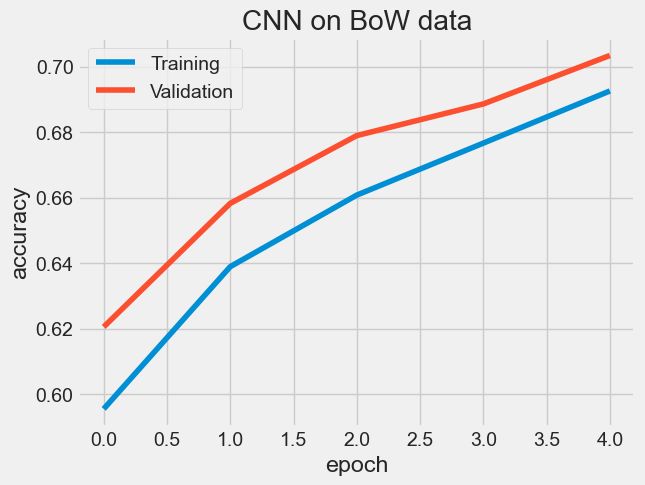

In [58]:
plt.title('CNN on BoW data')

plt.plot(hist_df.score_accuracy, label='Training')
plt.plot(hist_df.val_score_accuracy, label='Validation')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.savefig(f'../figs/{name}.png')
plt.show()

In [15]:
model = keras.models.load_model('../models/amz_lstm', custom_objects={'score_accuracy': score_accuracy, 'score_distance': score_distance})

In [18]:
res = model.predict(X_test)

3553/3553 [==============================] - 114s 32ms/step


In [30]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(interpret_result(y_test.astype(int)).numpy(), interpret_result(res).numpy())
conf_mat

array([[ 4561,  3535,  1141,   691,   339],
       [  736,  2604,  1722,   783,   340],
       [  143,  1507,  3550,  2242,  1008],
       [   48,   411,  1852,  6398,  7520],
       [   92,   666,  1573,  7373, 62856]], dtype=int64)

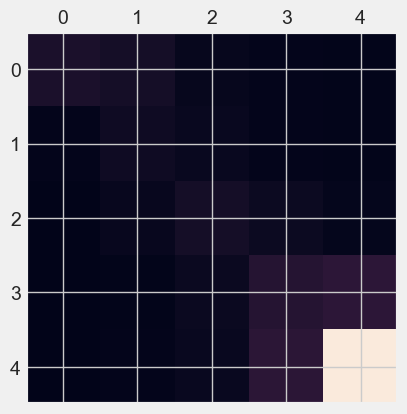

In [31]:
plt.matshow(conf_mat)

In [32]:
np.mean(interpret_result(y_test.astype(int)).numpy() == interpret_result(res).numpy())

0.7033890105637209